### English & Spanish
<hr>

1. Asignar activos, cash inicial, peso por activo, benchmark, fecha para la descarga y fecha de inicio del portfolio.
2. Descargamos los valores.
3. Asignamos la inversión inicial por peso por activo
4. Preparamos las acciones iniciales por activo dependiendo del peso asignado
5. Realizamos el engine de rebalanceo (diario, mensual o anual) leer en la intro.
6. Calculamos las métricas y valores del portfoilo y variación en pesos
7. Visualizamos
8. Realizamos el estudio en pyfolio para la estrategia. Tenemos que aplicar una unificación en zonas en el índice.

<hr>

1. Define assets, initial cash, weight per asset, benchmark, download starting date and live portfolio start date.
2. We download the values.
3. We assign the initial investment and weight per asset
4. We prepare the initial shares per asset depending on the assigned weight
5. We perform the rebalancing engine (daily, monthly or yearly) read in the intro.
6. We calculate the metrics and values ​​of the portfolio and variation in weights
7. We visualize
8. We carry out the study in pyfolio for the strategy. We need to localize timezones for this example.


In [1]:
# Selecting libraries
import yfinance as yf
import pandas as pd
import numpy as np
import pyfolio as py
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings("ignore")

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
c:\Users\javie\miniconda3\lib\site-packages\pyfolio\pos.py:25: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


In [17]:
# Define the assets and key initial metrics as investment amount to generate a portfolio

stocks = ['SPY', '^TNX', 'TIP', 'GLD', 'DBC' ]  # Assets to select yfinance format
portfolio_value = 10**6                         # Initial Portfolio Value to be allocated in full
weights = [0.30 , 0.15, 0.40, 0.075, 0.075]          # Weight Allocation per asset

benchmark = '^GSPC'                    # Which is your benchmark? ^GSPC is SP500 for Yfinance library

start_date = '2010-01-01'              # Start date for asset data download
live_date = '2020-01-01'               # Portfolio LIVE start date (for analytics)


# Warning handling
if len(weights) != len(stocks):
    print(sum((np.array(weights))))
    print('Number of Asset does not match weight allocated')
    
if sum((np.array(weights))) != 1.0:
    print(sum((np.array(weights))))
    print('Weight could not be allocated properly, make sure they sum 1.0')


0.9999999999999999
Weight could not be allocated properly, make sure they sum 1.0


In [3]:
# Download data, clean and isolate values for calculation
# If you use other data source, make sure the format is the same than stock_data.head() on next cell. Check dtypes by stock_data.info()

stock_data = yf.download(stocks, start=start_date)['Adj Close']
stock_data = stock_data.dropna()
stock_data = stock_data.reindex(columns=stocks)
stock_prices = stock_data[stocks].values

[*********************100%***********************]  5 of 5 completed


In [4]:
stock_data.head(3)

SPY   ^TNX        TIP         GLD        DBC
Date                                                          
2010-01-04  88.454193  3.841  75.740181  109.800003  24.376337
2010-01-05  88.688339  3.755  75.987419  109.699997  24.405312
2010-01-06  88.750801  3.808  75.791039  111.510002  24.839912

In [5]:
shares_df = pd.DataFrame(index=[stock_data.index[0]])

for s,w in zip(stocks, weights):
    shares_df[s + '_shares'] = np.floor((portfolio_value * np.array(w)) / stock_data[s][0])

shares_df    

SPY_shares  ^TNX_shares  TIP_shares  GLD_shares  DBC_shares
2010-01-04      3391.0      39052.0      5281.0       683.0      3076.0

In [6]:
# REBALANCING ENGINE (change between .year, .month, .day to execute the rebalancing)

# set initial shares on the first day
shares_df.loc[stock_data.index[0], :] = [np.floor((portfolio_value * w) / stock_data[s][0]) for s,w in zip(stocks, weights)]

# initialize variables
balance_year = stock_data.index[0].year
signal = False
count = 0    # for loop count purpose

# Store previous values in a dictionary
prev_values = {}

# Calculate portfolio value for the first day
portfolio_value = sum([shares_df.loc[stock_data.index[0], s + '_shares'] * stock_data.loc[stock_data.index[0], s] for s in stocks])

for day in stock_data.index:
    count += 1
    if day == stock_data.index[0]:
        shares_df.loc[day] = shares_df.loc[day] # First day

        # Store initial values as previous values
        for col in shares_df.columns:
            prev_values[col] = shares_df.loc[day, col]


    elif day.year != balance_year:
        signal = True
        # calculate new shares based on the new portfolio value and weights
        new_shares = [np.floor((portfolio_value * w) / stock_data[s][day]) for s,w in zip(stocks, weights)]
        shares_df.loc[day, :] = new_shares
        balance_year = day.year
        count += 1
        # print(f'Rebalance: {day.date()}, count: {count}') # uncomment to debug days ;)
        # Store new values as previous values
        for col in shares_df.columns:
            prev_values[col] = shares_df.loc[day, col]

    else:

        signal = False

        # Use previous values if it is not a rebalancing date
        shares_df.loc[day, :] = [prev_values[col] for col in shares_df.columns]
        
        # print(f'Not rebalance, regular day: {day.date()}') # uncomment to debug days ;)



    # Calculate asset values and portfolio value for the current day
    asset_values = [shares_df.loc[day, s + '_shares'] * stock_data.loc[day, s] for s in stocks]
    portfolio_value = sum(asset_values)
    
    stock_data.loc[day, 'Signal'] = signal
    stock_data.loc[day, 'Portfolio_Value'] = portfolio_value
    
    # Add shares to stock data frame
    for s in stocks:
        stock_data.loc[day, s + '_shares'] = shares_df.loc[day, s + '_shares']
        stock_data.loc[day, s + '_value'] = shares_df.loc[day, s + '_shares'] * stock_data.loc[day, s]


In [7]:
# Calculate log returns for portfolio
stock_data['Portfolio_Value_rets'] = np.log(stock_data['Portfolio_Value'] / stock_data['Portfolio_Value'].shift(1))

# Calculate log returns for each stock
for stock in stocks:
    stock_data[f'{stock}_rets'] = np.log(stock_data[stock] / stock_data[stock].shift(1))



In [8]:
start_date_benchmark = stock_data.index[0]
stock_data = stock_data.dropna()

In [9]:
# Calculate daily weight per asset
for s in stocks:
    stock_data[s + '_weight'] = stock_data[s + '_value'] / stock_data['Portfolio_Value']

In [10]:
stock_data.filter(regex='weight')

SPY_weight  ^TNX_weight  TIP_weight  GLD_weight  DBC_weight
Date                                                                   
2010-01-05    0.301143     0.146836    0.401825    0.075025    0.075171
2010-01-06    0.300208     0.148341    0.399260    0.075973    0.076218
2010-01-07    0.301172     0.148737    0.399471    0.075426    0.075194
2010-01-08    0.301687     0.147953    0.399667    0.075679    0.075014
2010-01-11    0.301897     0.148238    0.398510    0.076631    0.074725
...                ...          ...         ...         ...         ...
2023-02-22    0.308633     0.152515    0.393545    0.073084    0.072223
2023-02-23    0.309738     0.150544    0.394151    0.072919    0.072649
2023-02-24    0.307640     0.153866    0.393125    0.072680    0.072690
2023-02-27    0.308332     0.152637    0.393482    0.072881    0.072668
2023-02-28    0.306993     0.152305    0.394701    0.073165    0.072835

[3307 rows x 5 columns]

In [11]:
fig = go.Figure()

# Loop through each stock and add a trace for its shares
for stock in stocks:
    fig.add_trace(go.Scatter(x=stock_data.index, y=shares_df[stock+'_shares'], mode='lines', name=stock+'_shares'))

fig.update_layout(title='Shares per day',
                  xaxis_title='Date',
                  yaxis_title='Shares',
                  width=800,
                  height=400)

fig.show()

In [12]:
fig = go.Figure()

# Loop through each stock and add a trace for its shares
for stock in stocks:
    fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data[stock + '_weight'], mode='lines', name=stock + '_weight'))

fig.update_layout(title='Weights per day',
                  xaxis_title='Date',
                  yaxis_title='Weights',
                  width=1000,
                  height=600)

fig.show()

In [13]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# Create subplot layout
fig = make_subplots(rows=2, cols=2, subplot_titles=('Portfolio Returns', 'Asset Returns', 'Shares Holding per Asset', 'Weights per Asset'))

# Add traces to the subplots
fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data['Portfolio_Value_rets'].cumsum(), name='Portfolio'), row=1, col=1)

for s in stocks:
    fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data[f'{s}_rets'].cumsum(), name=f'{s}'), row=1, col=2)
    fig.add_trace(go.Scatter(x=shares_df.index, y=shares_df[f'{s}_shares'], name=f'{s}'), row=2, col=1)
    fig.add_trace(go.Scatter(x=stock_data.index, y=stock_data[f'{s}_weight'], name=f'{s}'), row=2, col=2)

# Update subplot layout
fig.update_layout(height=800, width=1200, title='Strategy Overview', showlegend=False)

# Display the plot
fig.show()


### STRATEGY ANALYTICS AND BENCHMARK INTEGRATION
<hr>

In [14]:
# Benchmark data download and returns
start_date_benchmark = stock_data.index[0]
benchmark_data = yf.download(benchmark, start=start_date_benchmark)
benchmark_data = benchmark_data.dropna()
benchmark_data['benchmark_rets'] = np.log(benchmark_data['Adj Close'] / benchmark_data['Adj Close'].shift(1))
benchmark_data['benchmark_rets'] = benchmark_data['benchmark_rets'].dropna()


[*********************100%***********************]  1 of 1 completed


In [15]:
# Data timezone unification for pyfolio valuation
stock_data.index = stock_data.index.tz_localize('UTC')
benchmark_data.index = benchmark_data.index.tz_localize('UTC')
live_date = pd.Timestamp(live_date, tz='UTC')

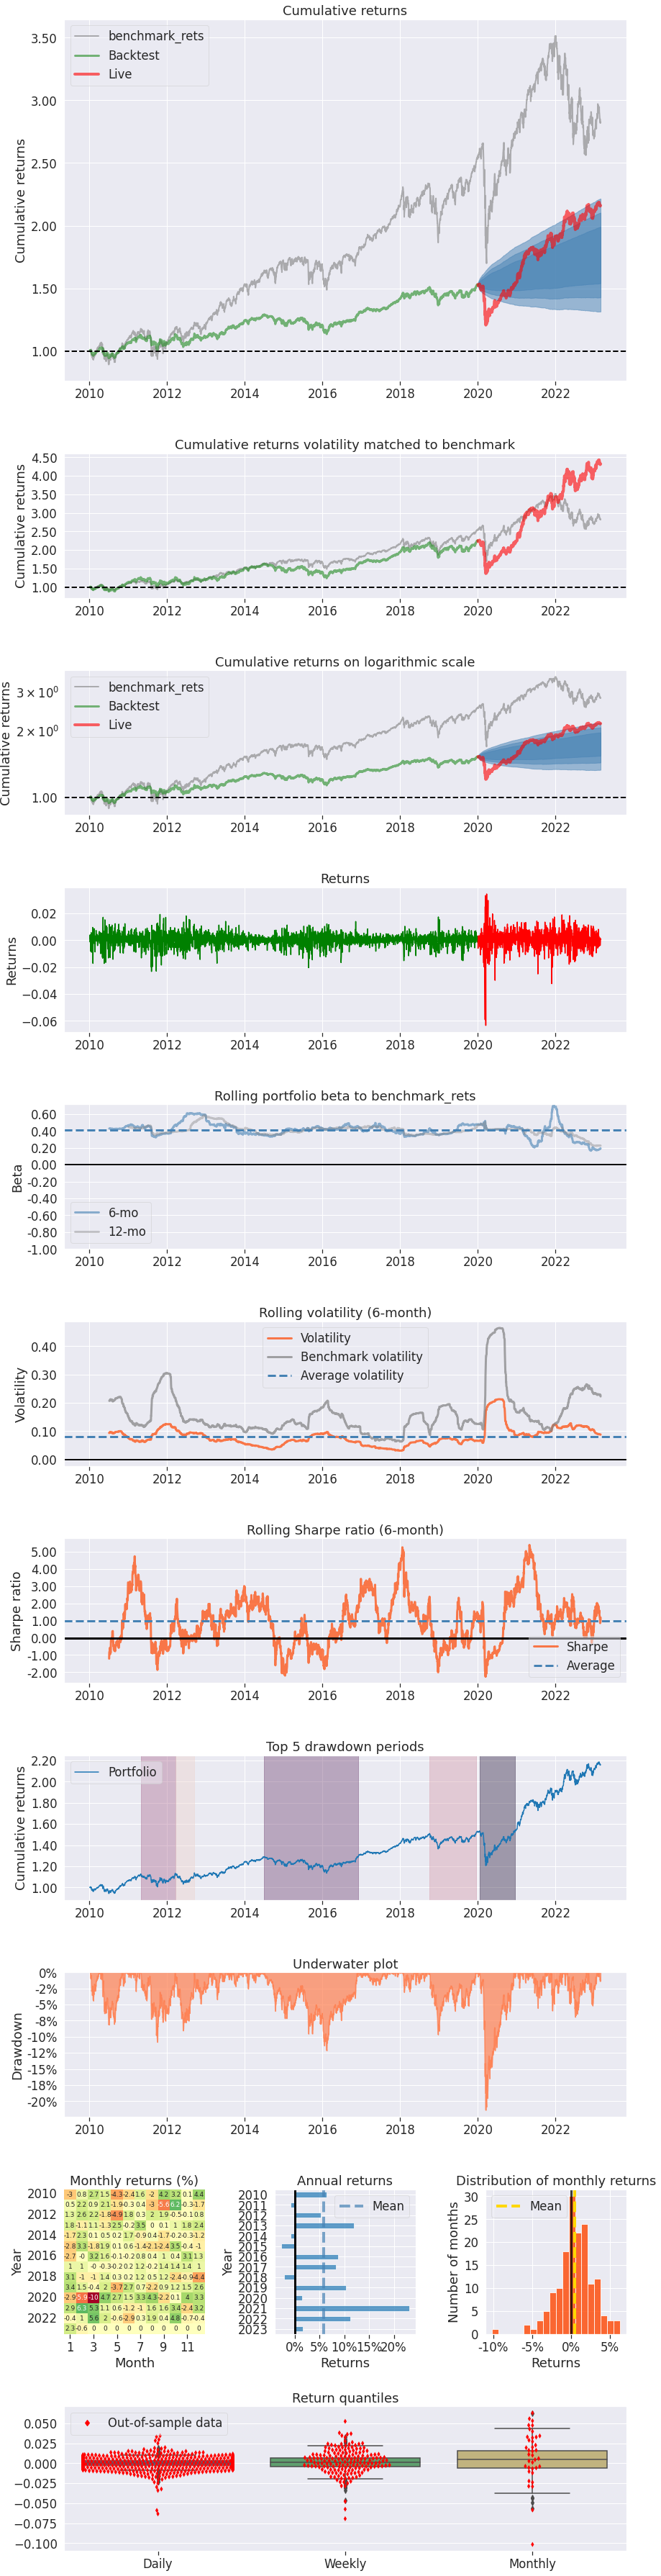

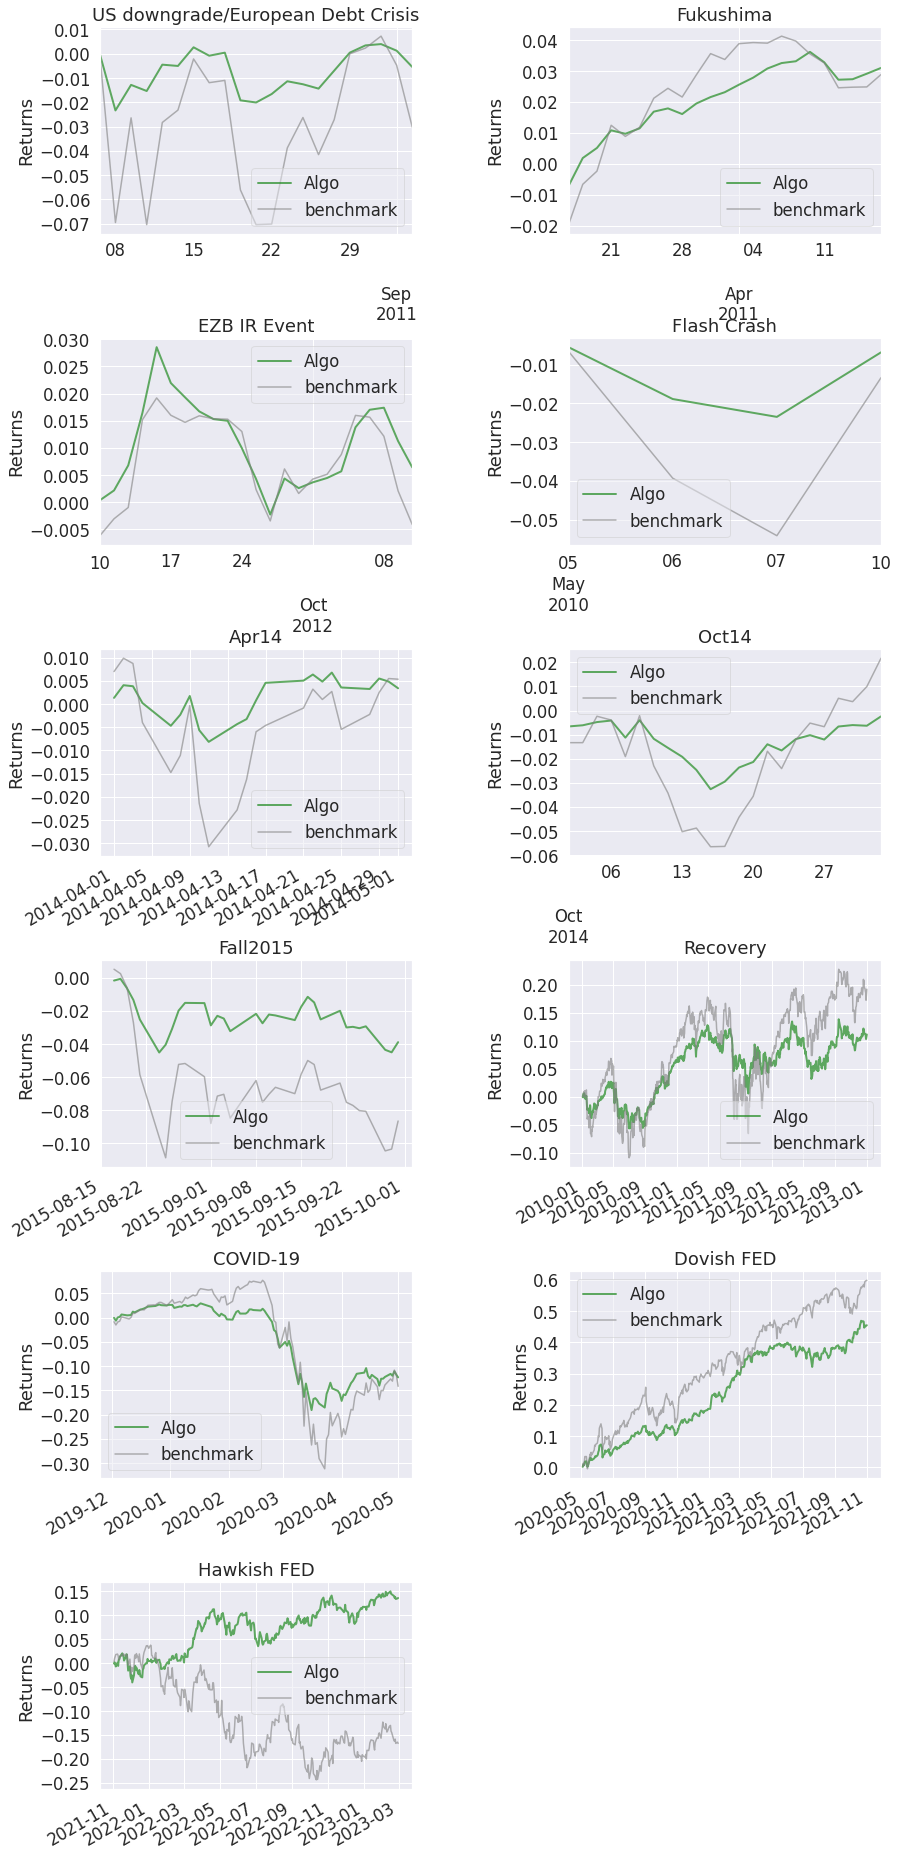

In [16]:
py.create_full_tear_sheet(stock_data['Portfolio_Value_rets'], benchmark_rets = benchmark_data['benchmark_rets'], live_start_date = live_date)